In [1]:
import numpy as np
import figure_options
from scipy.stats import hmean
from figure_options import plt, sns, rc_parameters
from tqdm import tqdm
from baifg.utils.characteristic_time import compute_characteristic_time_gaussian
from baifg.utils.graphs import make_loopystar_graph
from baifg.utils.utils import approximate_solution

colors = ['#00bfc4', 'mediumorchid', '#7f7f7f','#f8766d', '#3B3B3B','#0096FF','#a3a500']

In [2]:
K = 5
eps = 0
N = 200
pvalues = np.linspace(0, 1, N)
solutions = {
    f'q{i}': {
        'T': np.zeros(N),
        'w': np.zeros((N,K)),
        'm': np.zeros((N,K)),
        'approximate_sol':  np.zeros((N,K)),
    } for i in range(2)
}

for idx, p in enumerate(tqdm(pvalues)):
    for qid, q in enumerate([1, 0.25]):
        fg = make_loopystar_graph(p, q=q, r=0.25, K=K)
        sol = compute_characteristic_time_gaussian(fg)
        solutions[f'q{qid}']['T'][idx] = sol.value
        solutions[f'q{qid}']['w'][idx] = sol.wstar
        solutions[f'q{qid}']['m'][idx] = sol.mstar
        solutions[f'q{qid}']['approximate_sol'][idx] = approximate_solution(fg.reward_model, fg.graph)



100%|██████████| 200/200 [00:22<00:00,  8.94it/s]


## Plot characteristic time and information 

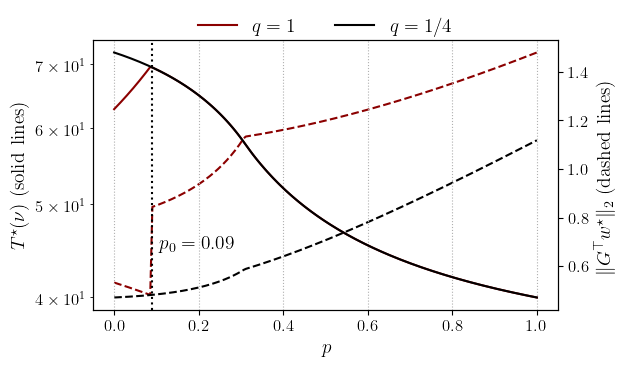

In [3]:
fig,ax = plt.subplots(1,1,figsize=(6,3.5))
p0 =pvalues[np.argwhere(np.abs(solutions['q0']['T']- solutions['q1']['T']) < 1e-3)[0]]

ax.plot(pvalues, solutions['q0']['T'],  label=r'$q=1$', color='darkred', zorder=3)
ax.plot(pvalues, solutions['q1']['T'],  label=r'$q=1/4$', color='k', zorder=3)
ax.axvline(x=p0.item(), color='black', linestyle=':', zorder=2)
ax.text(p0.item()*1.15, 45, f'$p_0 = {p0.item():.2f}$', zorder=2)

ax.set_yscale('log')
ax.set_xlabel(r'$p$')
ax.set_ylabel(r"$T^\star(\nu)$ (solid lines)")

ax.grid(linestyle = ":")

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncols=2, frameon=False)
ax2 = plt.twinx()
ax2.plot(pvalues, np.linalg.norm(solutions['q0']['m'], axis=-1), '--', color='darkred', zorder=1)#hmean(Mavg1, -1))
ax2.plot(pvalues, np.linalg.norm(solutions['q1']['m'], axis=-1), '--', color='k', zorder=1)# hmean(Mavg2, -1))
ax2.set_ylabel(r'$\|G^\top w^\star\|_2$ (dashed lines)')


ax.set_zorder(1)  # default zorder is 0 for ax1 and ax2
ax.patch.set_visible(False)  # prevents ax1 from hiding ax2

plt.savefig('figures/examples/characteristic_time_loopystar.pdf', bbox_inches='tight')

## Plot difference between true solution and approximate solution

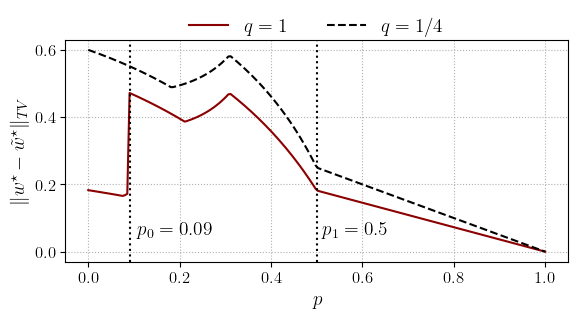

In [4]:
fig,ax = plt.subplots(1,1,figsize=(6,3.5))
x = solutions['q0']['w']
y = solutions['q0']['approximate_sol']
y = y / y.sum(axis=-1, keepdims=True)
ax.plot(pvalues, 0.5*np.linalg.norm(x-y, ord=1, axis=-1), label=r'$q=1$', color='darkred')
x = solutions['q1']['w']
y = solutions['q1']['approximate_sol']
y = y / y.sum(axis=-1, keepdims=True)
ax.plot(pvalues, 0.5*np.linalg.norm(x-y, ord=1, axis=-1), '--k', label=r'$q=1/4$')
ax.axvline(x=p0.item(), color='black', linestyle=':')
ax.axvline(x=0.5, color='black', linestyle=':')

ax.text(p0.item()*1.15, 0.05, f'$p_0 = {p0.item():.2f}$')
ax.text(0.51, 0.05, f'$p_1 = 0.5$')

# ax.set_yscale('log')
ax.set_xlabel(r'$p$')
ax.set_ylabel(r'$\|w^\star - \tilde w^\star\|_{TV}$')

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.18), ncols=2, frameon=False)

plt.grid(linestyle = ":")
plt.tight_layout()
plt.savefig('figures/examples/approx_sol_loopystar.pdf', bbox_inches='tight')

## Plot $w^\star, \tilde w^\star$ and $m^\star$ for different values of $p$ and $q$

In [9]:
def plot_w(solutions0, solutions1, xticks, par, label, namefile):
    width = 0.15  # the width of the bars

    fig, ax = plt.subplots(1,2, figsize=(10,3.5))
    x = np.arange(solutions0.shape[0])
    for idx, solutions in enumerate([solutions0, solutions1]):
        for i in range(solutions.shape[1]):
            ax[idx].bar(x + i*width, solutions[:, i], width, label=f'${label}_{i+1}^\star$')

        # Add labels, title, and custom x-axis tick labels
        ax[idx].set_xlabel(r'$p$')
        
        ax[idx].set_title(f'Loopy star with {par[idx]}' )
        ax[idx].set_xticks(x + width*2)
        ax[idx].set_xticklabels(xticks)
    ax[0].set_ylabel(f'${label}^\star$')
    ax[-1].legend(handlelength=1, bbox_to_anchor=(1.3, 1.05))


    plt.tight_layout()
    plt.savefig(f'figures/examples/{namefile}.pdf', bbox_inches='tight')

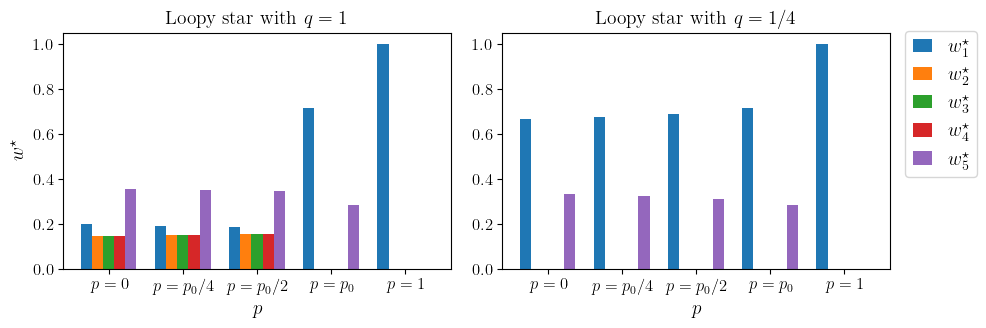

In [6]:

sol0 = compute_characteristic_time_gaussian(make_loopystar_graph(p=0, q=1, r=0.25,  K=K))
sol1 = compute_characteristic_time_gaussian(make_loopystar_graph(p=p0.item()/4, q=1, r=0.25,  K=K))
sol2 = compute_characteristic_time_gaussian(make_loopystar_graph(p=p0.item()/2, q=1, r=0.25,  K=K))
sol3 = compute_characteristic_time_gaussian(make_loopystar_graph(p=p0.item(), q=1, r=0.25,  K=K))
sol4 = compute_characteristic_time_gaussian(make_loopystar_graph(p=1, q=1, r=0.25,  K=K))
solutions_0 = np.vstack([sol0.wstar, sol1.wstar, sol2.wstar, sol3.wstar, sol4.wstar])


sol0 = compute_characteristic_time_gaussian(make_loopystar_graph(p=0, q=0.25, r=0.25,  K=K))
sol1 = compute_characteristic_time_gaussian(make_loopystar_graph(p=p0.item()/4, q=0.25, r=0.25,  K=K))
sol2 = compute_characteristic_time_gaussian(make_loopystar_graph(p=p0.item()/2, q=0.25, r=0.25,  K=K))
sol3 = compute_characteristic_time_gaussian(make_loopystar_graph(p=p0.item(), q=0.25, r=0.25,  K=K))
sol4 = compute_characteristic_time_gaussian(make_loopystar_graph(p=1, q=0.25, r=0.25,  K=K))
solutions_1 = np.vstack([sol0.wstar, sol1.wstar, sol2.wstar, sol3.wstar, sol4.wstar])

plot_w(solutions_0, solutions_1,['$p=0$','$p=p_0/4$', '$p=p_0/2$', '$p=p_0$', '$p=1$'], 
       ["$q=1$", "$q=1/4$"], label='w', namefile='allocations_loopystar')



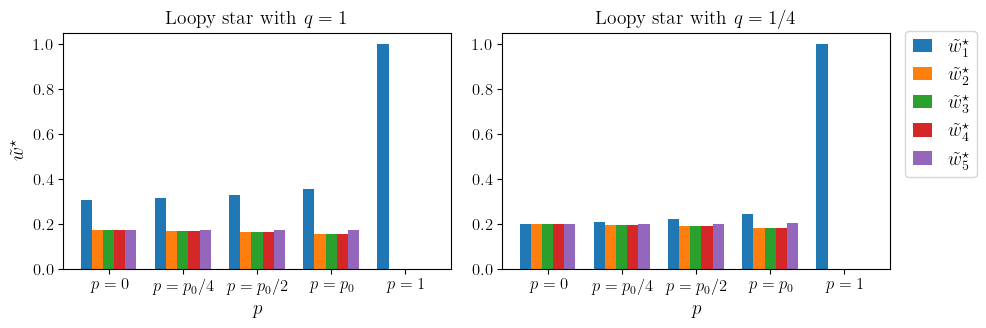

In [7]:

solutions = []
for p  in [0, p0.item()/4, p0.item()/2, p0.item(), 1]:
    env = make_loopystar_graph(p=p, q=1, r=0.25,  K=K)
    y = approximate_solution(env.reward_model, env.graph)
    y = y/y.sum()
    solutions.append(y)
solutions_0 = np.vstack(solutions)

solutions = []
for p  in [0, p0.item()/4, p0.item()/2, p0.item(), 1]:
    env = make_loopystar_graph(p=p, q=0.25, r=0.25,  K=K)
    y = approximate_solution(env.reward_model, env.graph)
    y = y/y.sum()
    solutions.append(y)
solutions_1 = np.vstack(solutions)


plot_w(solutions_0, solutions_1,['$p=0$','$p=p_0/4$', '$p=p_0/2$', '$p=p_0$', '$p=1$'], ["$q=1$", "$q=1/4$"],
       label=r"\tilde w", namefile='approx_w_loopystar')


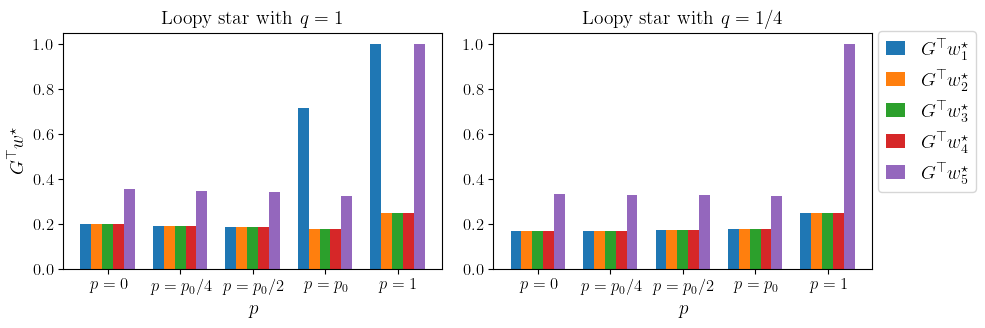

In [10]:

sol0 = compute_characteristic_time_gaussian(make_loopystar_graph(p=0, q=1, r=0.25,  K=K))
sol1 = compute_characteristic_time_gaussian(make_loopystar_graph(p=p0.item()/4, q=1, r=0.25,  K=K))
sol2 = compute_characteristic_time_gaussian(make_loopystar_graph(p=p0.item()/2, q=1, r=0.25,  K=K))
sol3 = compute_characteristic_time_gaussian(make_loopystar_graph(p=p0.item(), q=1, r=0.25,  K=K))
sol4 = compute_characteristic_time_gaussian(make_loopystar_graph(p=1, q=1, r=0.25,  K=K))
solutions_0 = np.vstack([sol0.mstar, sol1.mstar, sol2.mstar, sol3.mstar, sol4.mstar])


sol0 = compute_characteristic_time_gaussian(make_loopystar_graph(p=0, q=0.25, r=0.25,  K=K))
sol1 = compute_characteristic_time_gaussian(make_loopystar_graph(p=p0.item()/4, q=0.25, r=0.25,  K=K))
sol2 = compute_characteristic_time_gaussian(make_loopystar_graph(p=p0.item()/2, q=0.25, r=0.25,  K=K))
sol3 = compute_characteristic_time_gaussian(make_loopystar_graph(p=p0.item(), q=0.25, r=0.25,  K=K))
sol4 = compute_characteristic_time_gaussian(make_loopystar_graph(p=1, q=0.25, r=0.25,  K=K))
solutions_1 = np.vstack([sol0.mstar, sol1.mstar, sol2.mstar, sol3.mstar, sol4.mstar])

plot_w(solutions_0, solutions_1,['$p=0$','$p=p_0/4$', '$p=p_0/2$', '$p=p_0$', '$p=1$'], ["$q=1$", "$q=1/4$"],
       label=r'G^{\top} w', namefile='mstar_loopystar')
